# Final Notebook: Poisoning, Data Selection, and Pruning
**Comparing:** Full data, Random subset, EL2N, Forgettability, and CRAIG-approx selection methods.

This notebook runs prototype experiments on CIFAR-10 with label-flip and backdoor poisons, computes
attack success rate (ASR), poison retention, clean accuracy, and shows comparison plots.

**Usage:** Set `PROTOTYPE = True` for quick runs on Colab/GPU. For final experiments, set `PROTOTYPE=False` and
increase epochs and repetitions.


In [1]:
# -------------------------
# Google Colab Setup
# -------------------------
try:
    import google.colab
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
    os.chdir("/content/drive/Othercomputers/My MacBook Pro/final_project_pruning")
    print(f"Changed directory to: {os.getcwd()}")
except:
    pass  # Not in Colab, skip mounting

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Changed directory to: /content/drive/Othercomputers/My MacBook Pro/final_project_pruning


In [2]:
# -------------------------
# Setup: installs, imports, reproducibility
# -------------------------
PROTOTYPE = False  # set False for full experiments

import random
import numpy as np
import torch, torch.optim as optim

# Seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

Device: cuda


In [3]:
# -------------------------
# Data transforms & load CIFAR-10
# -------------------------
if PROTOTYPE:
    train_epochs = 8
    batch_size = 128
    subset_frac = 0.25
    el2n_epochs = 2
    forget_epochs = 3
    craig_pretrain_epochs = 3
    num_workers = 0
else:
    train_epochs = 50
    batch_size = 128
    subset_frac = 0.5
    el2n_epochs = 5
    forget_epochs = 10
    craig_pretrain_epochs = 5

data_root = './data'
num_workers = 0

In [4]:
from dataset import data_loaders
train_set, test_set, train_loader_full, test_loader = data_loaders(data_root, batch_size, num_workers)

Loaded CIFAR-10: train size 50000 test size 10000


In [5]:
from dataset import new_backdoor_dataset
from train_utils import *
from utils import *
from model import get_model
from el2n import compute_el2n_scores
from forgetting import compute_forgetting_scores
from craig import select_subset_craig
from prune import iterative_magnitude_prune_and_retrain
from torch.utils.data import DataLoader

# -------------------------
# Orchestrate all methods and evaluate
# -------------------------
def run_all_methods(poison_frac=0.02, subset_frac=0.25, selection_methods=None, device='cuda', num_workers=4):
    if selection_methods is None:
        selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']

    results = {}

    # 1. Prepare Backdoor Dataset
    # We no longer check for poison_type; we assume backdoor.
    ds_poisoned = new_backdoor_dataset(data_root, poison_frac=poison_frac)
    poisoned_set = ds_poisoned.poisoned_idx

    n = len(ds_poisoned)
    k = int(n * subset_frac)
    print(f'Running Backdoor, poison_frac={poison_frac}, subset size {k} (of {n})')

    for method in selection_methods:
        print(f'\n---- Selection method: {method} ----')

        # 2. Select Indices
        if method == 'full':
            indices = list(range(n))
        elif method == 'random':
            indices = sample_random_indices(ds_poisoned, k, seed=seed)
        elif method == 'el2n':
            scores = compute_el2n_scores(get_model, ds_poisoned,
                                       epochs=el2n_epochs, device=device, num_workers=num_workers)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'forget':
            scores = compute_forgetting_scores(get_model, ds_poisoned,
                                             epochs=forget_epochs, device=device, num_workers=num_workers)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'craig':
            indices = select_subset_craig(get_model, ds_poisoned,
                                        subset_size=k, device=device, num_workers=num_workers,
                                        pretrain_epochs=craig_pretrain_epochs, warmup_epochs=2, seed=seed)

        kept, total_poison, retention = compute_poison_retention(poisoned_set, indices)
        print(f'Poison retention: {kept}/{total_poison} ({retention:.4f})')

        subset = subset_from_indices(ds_poisoned, indices)

        # 3. Train Dense Model with History Tracking
        model = get_model(device=device)
        opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=train_epochs, eta_min=1e-5)
        crit = nn.CrossEntropyLoss()

        train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        # Use train_with_history wrapper to track losses
        model, history = train_with_history(
            model, train_loader, test_loader, opt, scheduler, crit,
            epochs=train_epochs, device=device
        )

        # 4. Evaluate Dense Model
        loss, acc = evaluate(model, test_loader, device=device)

        # Removed the 'if poison_type == ...' check
        asr = compute_backdoor_asr(model, test_loader, trigger_patch_size=6, target_label=0, device=device)

        print(f'Dense model - Clean accuracy: {acc:.4f}, ASR: {asr:.4f}')

        # 5. Pruning & Retraining
        print("Applying iterative magnitude pruning...")
        pruned_model, mask = iterative_magnitude_prune_and_retrain(
            get_model,
            subset,
            test_loader,
            fraction_to_prune=0.3,
            iterations=2,
            rewind_epoch=1,
            epochs_per_cycle=10,
            num_workers=num_workers,
            device=device
        )

        ploss, pacc = evaluate(pruned_model, test_loader, device=device)
        pasr = compute_backdoor_asr(pruned_model, test_loader, trigger_patch_size=6, target_label=0, device=device)

        print(f'Pruned model - Clean accuracy: {pacc:.4f}, ASR: {pasr:.4f}')

        results[method] = {
            'subset_size': len(indices),
            'clean_acc': acc,
            'asr': asr,
            'poison_kept': kept,
            'poison_total': total_poison,
            'poison_retention': retention,
            'pruned_acc': pacc,
            'pruned_asr': pasr,
            'train_losses': history['train_losses'],
            'train_accs': history['train_accs'],
            'test_losses': history['test_losses'],
            'test_accs': history['test_accs'],
            'pruned_test_loss': ploss
        }

    return results

In [6]:
# selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']
selection_methods = ['craig']

In [7]:
# Backdoor experiment
res_backdoor = run_all_methods(poison_frac=0.02, subset_frac=subset_frac, selection_methods=selection_methods, device=device)
print('\nBackdoor results:'); print(res_backdoor)

Running Backdoor, poison_frac=0.02, subset size 25000 (of 50000)

---- Selection method: craig ----
Pre-training CRAIG model for 5 epochs (warmup: 2)...


  Epoch 1/5: Avg Loss = 2.3113


  Epoch 2/5: Avg Loss = 1.7355


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1090: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


  Epoch 3/5: Avg Loss = 1.2356


  Epoch 4/5: Avg Loss = 0.9390


  Epoch 5/5: Avg Loss = 0.7034
Computing CRAIG gradient embeddings on trained model...


Gradient embedding extraction took 5.45 seconds
Running CRAIG gradient matching (lazy=True)...
CRAIG gradient matching took 11.72 seconds
CRAIG selected 25000 items.
Poison retention: 723/1000 (0.7230)


Dense model - Clean accuracy: 0.5947, ASR: 0.9988
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...


Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.5138, ASR: 0.9876

Backdoor results:
{'craig': {'subset_size': 25000, 'clean_acc': 0.5947, 'asr': 0.9988, 'poison_kept': 723, 'poison_total': 1000, 'poison_retention': 0.723, 'pruned_acc': 0.5138, 'pruned_asr': 0.9876, 'train_losses': [1.90900953125, 1.250890390625, 1.048386171875, 0.88932484375, 0.732230859375, 0.608289765625, 0.5161066015625, 0.44414140625, 0.365530703125, 0.31230291015625, 0.263055078125, 0.23988921875, 0.21251318359375, 0.19744396484375, 0.1867478515625, 0.172361953125, 0.16345529296875, 0.145732734375, 0.15272984375, 0.131480458984375, 0.129805576171875, 0.1168875390625, 0.116548779296875, 0.108497314453125, 0.103200869140625, 0.090993720703125, 0.0805410595703125, 0.082125751953125, 0.07659248046875, 0.0653290283203125, 0.064523447265625, 0.0552248828125, 0.0459468359375, 0.0372087548828125, 0.03740869384765625, 0.0313945947265625, 0.0243681884765625, 0.017844561767578124, 0.014417646484375, 0.013021618652

In [8]:
from results import *

In [9]:
save_results_csv(res_backdoor, fname='backdoor_results_prototype.csv')

Saved results to backdoor_results_prototype.csv


In [10]:
# Save loss history to CSV
save_loss_history_csv(res_backdoor, fname='backdoor_loss_history_prototype.csv')

Saved loss history to backdoor_loss_history_prototype.csv


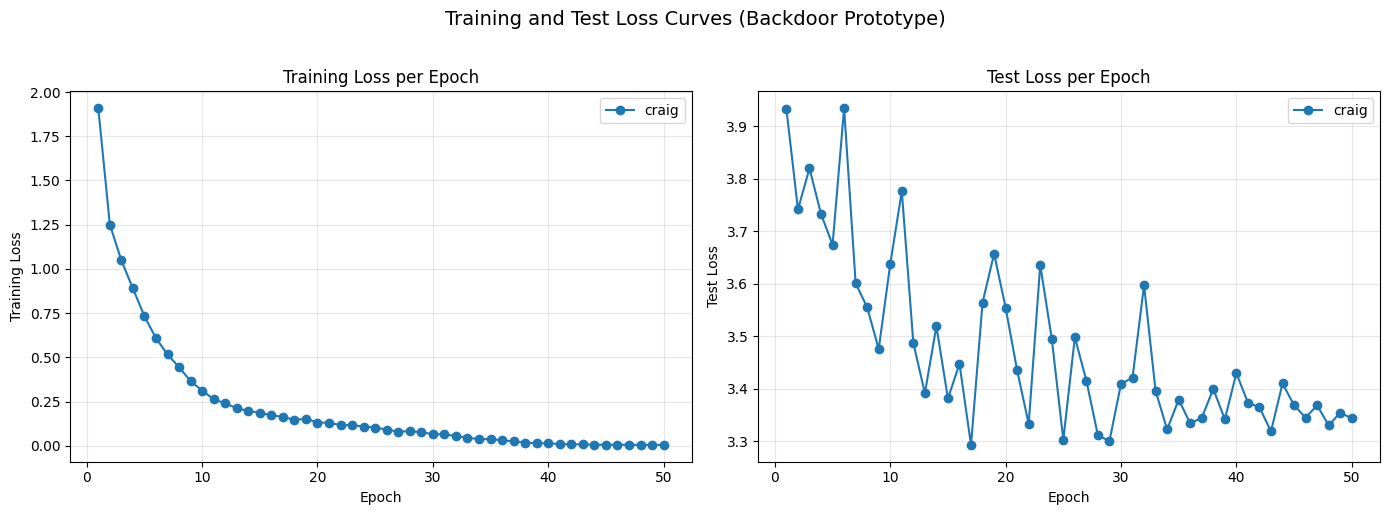

In [11]:
# Plot loss curves
plot_loss_curves(res_backdoor, title='Training and Test Loss Curves (Backdoor Prototype)')

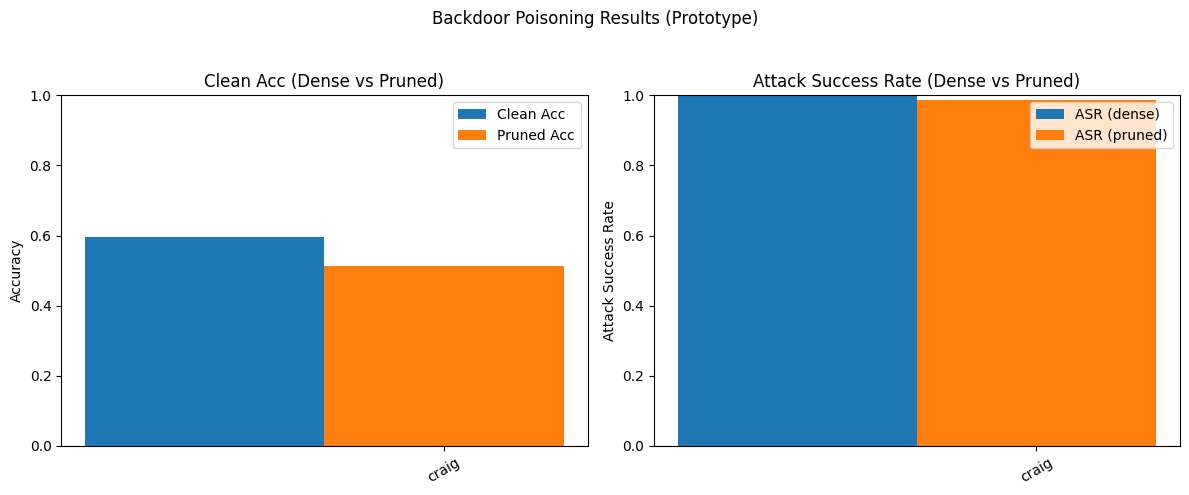

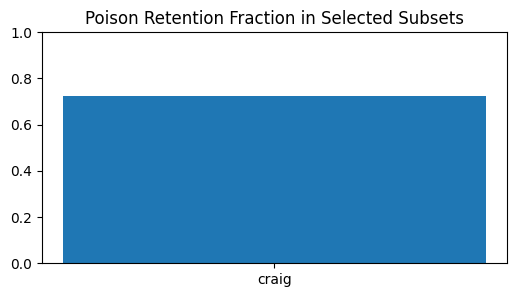

In [12]:
plot_results(res_backdoor, title='Backdoor Poisoning Results (Prototype)')